In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

In [5]:
def get_dataset(data_set_path): 
    return pd.read_csv(data_set_path, sep=',')

drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_smiles.csv")
metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/metxbiodb_smiles.csv")

clean_drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_smiles_clean.csv")
clean_metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/metxbiodb_smiles_clean.csv")

unique_drugbank = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/drugbank_unique_parents.csv")
unique_metxbiodb = get_dataset("/projects/cc/se_users/larsson_kbvs588/test/MasterThesis/dataset/curated_data/metxbiodb_unique_parents.csv")

In [6]:
def create_pychart(data, labels): 
    colors = ['#b7ded2', '#f6a6b2', '#f7c297', '#90d2d8']
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

def get_duplicates_from_datasets(dataset_first, dataset_second):
    equal_count = 0
    for i, row_db in dataset_first.iterrows():
        parent = row_db['parent_smiles']
        child = row_db['child_smiles']

        duplicated = dataset_second[(dataset_second["parent_smiles"] == parent) & (dataset_second["child_smiles"] == child)]

        if not duplicated.empty: 
            equal_count += 1 
            
    return equal_count

def data_source_analysis(dataset_first, dataset_first_name, dataset_second, dataset_second_name): 
    dataset_first = dataset_first[['parent_smiles', 'child_smiles']]
    dataset_second = dataset_second[['parent_smiles', 'child_smiles']]
    duplicate_count = get_duplicates_from_datasets(dataset_first, dataset_second)

    first_dataset_length = len(dataset_first) - duplicate_count
    second_dataset_length = len(dataset_second) - duplicate_count

    labels = [dataset_first_name, dataset_second_name]
    data = [first_dataset_length, second_dataset_length]
    
    if duplicate_count > 0: 
        print(f"Duplicates {duplicate_count}")
        data.append(duplicate_count)
        # labels.append(f"{dataset_first_name} and {dataset_second_name}")
        labels.append(f"Overlap")
    
    total_dataset_length = first_dataset_length + second_dataset_length + duplicate_count
    print('Total: ', total_dataset_length)
    create_pychart(data, labels)

Duplicates 41
Total:  3747


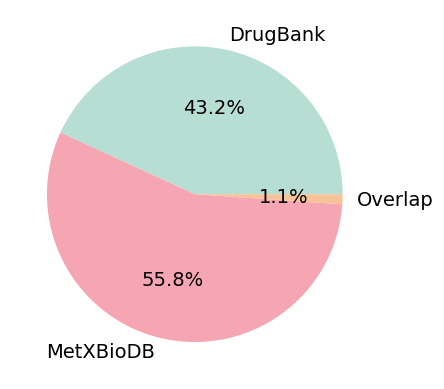

In [7]:
data_source_analysis(drugbank, 'DrugBank', metxbiodb, 'MetXBioDB')

Duplicates 61
Total:  3085


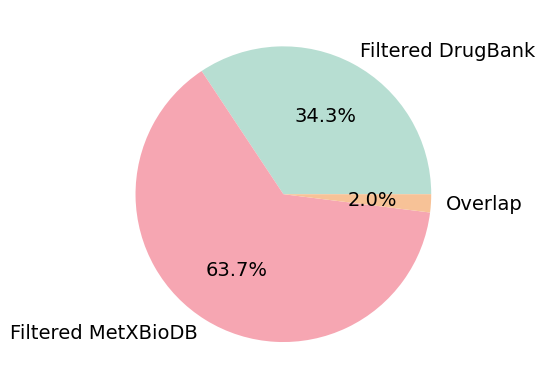

In [8]:
data_source_analysis(clean_drugbank, 'Filtered DrugBank', clean_metxbiodb, 'Filtered MetXBioDB')

Duplicates 17
Total:  1766


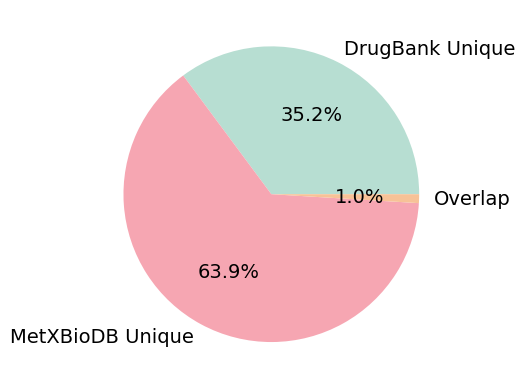

In [9]:
data_source_analysis(unique_drugbank, 'DrugBank Unique', unique_metxbiodb, 'MetXBioDB Unique')

In [2]:
def finger_print_similarity(dataset):
    parent_smiles = dataset['parent_smiles'].tolist()
    metabolite_smiles = dataset['child_smiles'].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    # parent_fps = [Chem.RDKFingerprint(x) for x in parent_mol]
    # metabolite_fps = [Chem.RDKFingerprint(x) for x in metabolite_mol]

    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    metabolite_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in metabolite_mol]

    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        
        s = DataStructs.TanimotoSimilarity(parent_fps[i],metabolite_fps[i]) 
        fingerprint_similarities.append(s)

    return fingerprint_similarities  

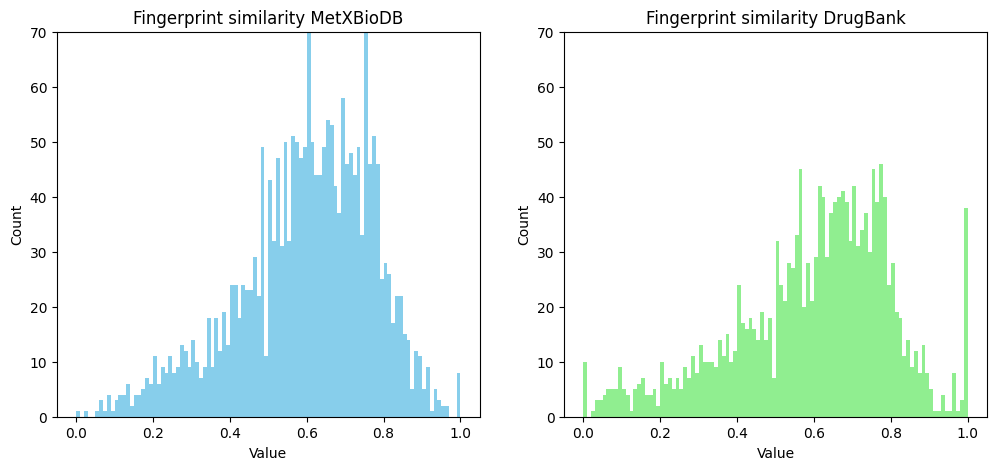

In [6]:
metxbiodb_similarities = finger_print_similarity(metxbiodb)
drugbank_similarities = finger_print_similarity(drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

ax[0].set_ylim(0, 70)
ax[1].set_ylim(0, 70)

plt.show()

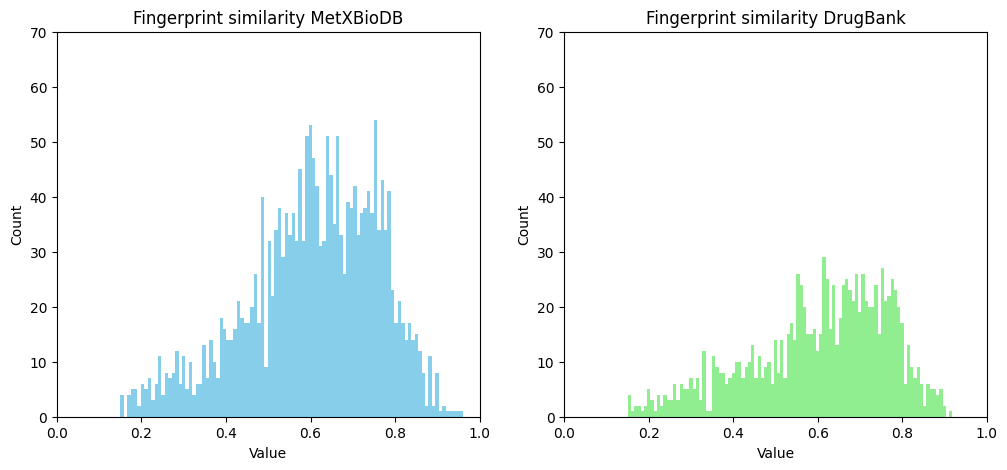

In [8]:
metxbiodb_similarities = finger_print_similarity(clean_metxbiodb)
drugbank_similarities = finger_print_similarity(clean_drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

ax[0].set_ylim(0, 70)
ax[1].set_ylim(0, 70)
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

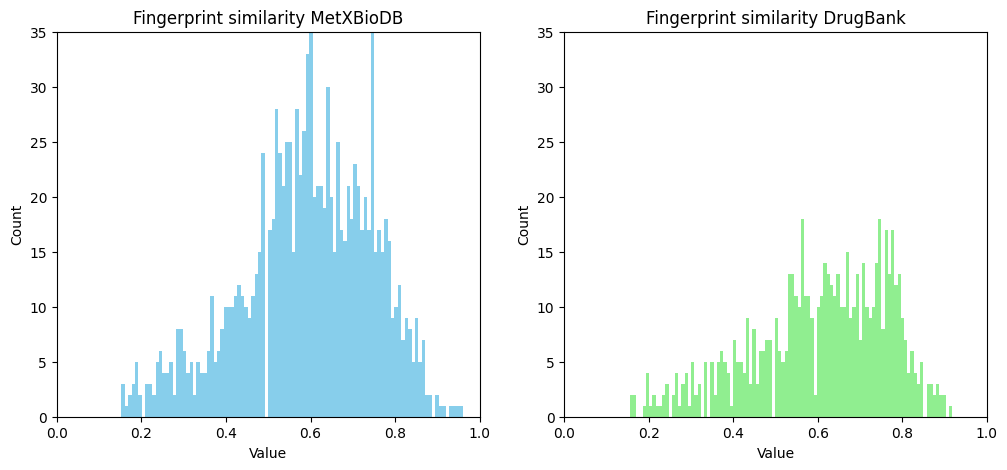

In [23]:
metxbiodb_similarities = finger_print_similarity(unique_metxbiodb)
drugbank_similarities = finger_print_similarity(unique_drugbank)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(metxbiodb_similarities, bins=100, color='skyblue')
ax[0].set_title('Fingerprint similarity MetXBioDB')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Count')

ax[1].hist(drugbank_similarities, bins=100, color='lightgreen')
ax[1].set_title('Fingerprint similarity DrugBank')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Count')

ax[0].set_ylim(0, 35)
ax[1].set_ylim(0, 35)
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

In [12]:
def plot_heavy_atoms(metabolite_weights, parent_weights, weights_diff):
    # Plot histograms for metabolite and parent weights side by side
    # fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # axes[0].hist(metabolite_weights, bins=50, color='skyblue')
    # axes[0].set_title('Metabolite Weights')
    # axes[0].set_xlabel('Molecular Weight (Da)')
    # axes[0].set_ylabel('Frequency')

    # axes[1].hist(parent_weights, bins=50, color='lightgreen')
    # axes[1].set_title('Parent Weights')
    # axes[1].set_xlabel('Molecular Weight (Da)')
    # axes[1].set_ylabel('Frequency')

    # # Make y-axes equal
    # histograms = [axes[0], axes[1]]
    # max_ylim = max(ax.get_ylim()[1] for ax in histograms)  # Find the maximum y-limit
    # for ax in histograms:
    #     ax.set_ylim(top=max_ylim)

    # plt.tight_layout()
    # plt.show()

    # Plot histogram for weight differences
    plt.figure(figsize=(6, 5))
    plt.hist(weights_diff, bins=40, color='magenta')
    plt.title('Heavy Atoms Differences (Parent - Metabolite)')
    plt.xlabel('Heavy Atoms  Difference (Da)')
    plt.ylabel('Frequency')
    plt.show()


def heavy_atoms_analysis(dataset):
    # Initialize lists to store counts of heavy atoms and differences
    children_ha, parents_ha, has_diff = [], [], []

    # Extract SMILES strings from the dataset
    parents = dataset["parent_smiles"]
    children = dataset["child_smiles"]

    for parent, child in zip(parents, children):
        # Convert SMILES to RDKit Mol objects
        parent_mol = Chem.MolFromSmiles(parent)
        child_mol = Chem.MolFromSmiles(child)
        
        # Count heavy atoms (non-hydrogen atoms) in parents and children
        parent_ha = sum(atom.GetAtomicNum() > 1 for atom in parent_mol.GetAtoms())
        child_ha = sum(atom.GetAtomicNum() > 1 for atom in child_mol.GetAtoms())

        # Append counts to corresponding lists
        parents_ha.append(parent_ha)
        children_ha.append(child_ha)

        # Calculate difference in heavy atom count and append to differences list
        ha_diff = parent_ha - child_ha
        has_diff.append(ha_diff)

    # Call the plotting function
    plot_heavy_atoms(children_ha, parents_ha, has_diff)

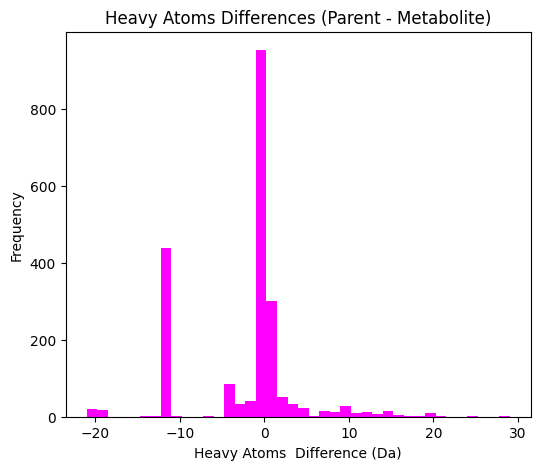

In [13]:
heavy_atoms_analysis(metxbiodb)

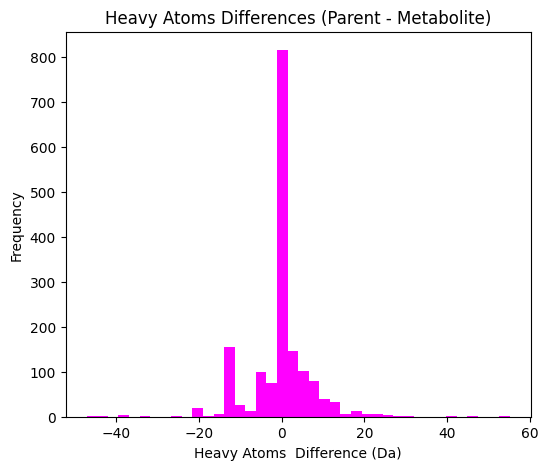

In [14]:
heavy_atoms_analysis(drugbank)

In [20]:
def molecular_weight_analysis(dataset): 
    weights_diff = []

    parents = dataset["parent_smiles"]
    metabolites = dataset["child_smiles"]

    for parent, metabolite in zip(parents, metabolites):
        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        weight_diff = parent_weight - metabolite_weight
        weights_diff.append((parent, metabolite, weight_diff))

    return weights_diff

def find_entries_in_bin(weights_diff, bin_range):
    print(f"Entries in the weight difference range {bin_range}:")
    for parent, metabolite, weight_diff in weights_diff:
        if bin_range[0] <= weight_diff < bin_range[1]:
            print(f"Parent SMILES: {parent}, Child SMILES: {metabolite}, Weight Difference: {weight_diff:.2f}")


In [21]:
weights_diff = molecular_weight_analysis(clean_drugbank)
find_entries_in_bin(weights_diff, (-200, -170))

# glucuronide 176.03

Entries in the weight difference range (-200, -170):
Parent SMILES: COCCCN1CCC(NC(=O)c2cc(Cl)c(N)c3c2OCC3)CC1, Child SMILES: COCCCN1CCC(NC(=O)c2cc(Cl)c(NOC3OC(C(=O)O)C(O)C(O)C3O)c3c2OCC3)CC1, Weight Difference: -192.03
Parent SMILES: CC1(C)SC2C(NC(=O)C(N)c3ccc(O)cc3)C(=O)N2C1C(=O)O, Child SMILES: CC1(C)SC2C(NC(=O)C(N)c3ccc(OC4OC(C(=O)O)C(O)C(O)C4O)cc3)C(=O)N2C1C(=O)O, Weight Difference: -176.03
Parent SMILES: CC12CCC3c4ccc(O)cc4CCC3C1CC(O)C2O, Child SMILES: CC12CCC3c4ccc(O)cc4CCC3C1CC(O)C2OC1OC(C(=O)O)C(O)C(O)C1O, Weight Difference: -176.03
Parent SMILES: CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O, Child SMILES: CC12CCC3C(CCC4CC(OC5OC(C(=O)O)C(O)C(O)C5O)CCC43C)C1CCC2O, Weight Difference: -178.05
Parent SMILES: CC(C(=O)O)c1cccc(Oc2ccccc2)c1, Child SMILES: CC(C(=O)OC1OC(C(=O)O)C(O)C(O)C1O)c1cccc(Oc2ccccc2)c1, Weight Difference: -176.03
Parent SMILES: CN1C(=O)C(O)N=C(c2ccccc2Cl)c2cc(Cl)ccc21, Child SMILES: CN1C(=O)C(OC2OC(C(=O)O)C(O)C(O)C2O)N=C(c2ccccc2Cl)c2cc(Cl)ccc21, Weight Difference: -176.03

In [22]:
weights_diff = molecular_weight_analysis(clean_metxbiodb)
find_entries_in_bin(weights_diff, (-200, -170))

# glucuronide at 176.03

Entries in the weight difference range (-200, -170):
Parent SMILES: O=C(OC1Cc2c(O)cc(O)cc2OC1c1cc(O)c(O)c(O)c1)c1cc(O)c(O)c(O)c1, Child SMILES: O=C(OC1Cc2c(O)cc(O)cc2OC1c1cc(O)c(O)c(OC2OC(C(=O)O)C(O)C(O)C2O)c1)c1cc(O)c(O)c(O)c1, Weight Difference: -176.03
Parent SMILES: O=C(OC1Cc2c(O)cc(O)cc2OC1c1cc(O)c(O)c(O)c1)c1cc(O)c(O)c(O)c1, Child SMILES: O=C(OC1Cc2c(O)cc(O)cc2OC1c1cc(O)c(OC2OC(C(=O)O)C(O)C(O)C2O)c(O)c1)c1cc(O)c(O)c(O)c1, Weight Difference: -176.03
Parent SMILES: Oc1cc(O)c2c(c1)OC(c1cc(O)c(O)c(O)c1)C(O)C2, Child SMILES: O=C(O)C1OC(Oc2cc(C3Oc4cc(O)cc(O)c4CC3O)cc(O)c2O)C(O)C(O)C1O, Weight Difference: -176.03
Parent SMILES: O=C(C=Cc1ccccc1O)c1ccccc1, Child SMILES: O=C(C=Cc1ccccc1OC1OC(C(=O)O)C(O)C(O)C1O)c1ccccc1, Weight Difference: -176.03
Parent SMILES: O=C(C=Cc1ccc(O)cc1)c1ccccc1, Child SMILES: O=C(C=Cc1ccc(OC2OC(C(=O)O)C(O)C(O)C2O)cc1)c1ccccc1, Weight Difference: -176.03
Parent SMILES: O=C(C=Cc1ccccc1)c1ccccc1O, Child SMILES: O=C(C=Cc1ccccc1)c1ccccc1OC1OC(C(=O)O)C(O)C(O)C1O, Weig